# 勾配法と誤差逆伝播法
ニューラルネットワークにおいて，効率よく各重みの勾配を推定することで貢献度割り当て問題を解決する方法が**誤差逆伝播法** (backpropagation) である．本節では入力層，隠れ層，出力層からなる多層ニューラルネットワークを実装し，誤差逆伝播法による勾配推定を用いて学習を行う．

本書では誤差逆伝播法を用いない学習法を実施することも考慮し，数式と対応するような実装を行う．そのため，Deep Learningライブラリ (PyTorch, Flux.jl等) のようにLayerを定義し，それを繋げてモデルを定義するということや計算グラフの構築は行わない．

In [1]:
using Base: @kwdef
using LinearAlgebra, Random, PyPlot, ProgressMeter, Statistics
rc("axes.spines", top=false, right=false)
include("../codes/neural_networks.jl")

train_step! (generic function with 1 method)

活性化関数 (activation function) の構造体を`ActivationFunction` と定義する．この構造体には`forward` と `backward`の2種類の関数フィールド (field; 構造体の要素のこと) を持たせておく．2種類の関数はそれぞれ順伝播時と逆伝播時に使用する．

In [2]:
# forward computation of MLP
function forward_perturb!(mlp::MLP, x::Array; mode="weight", σ=1e-2)
    (;L, f, W, b) = mlp
    n_batch = size(x)[1]
    z = Vector{Array}(undef, L+1) # define z (perturbed)
    z[1] = x # input (n_batch x n_neurons)
    # perturbation noise
    if mode == "weight"
        V = [σ * randn(n_batch, size(W[l].v)...) for l in 1:L]
    end
    v = [σ * randn(n_batch, size(b[l].v)[2]) for l in 1:L]
    
    for l in 1:L
        if mode == "weight"
            z[l+1] = f[l](vcat([z[l][i, :]' * (W[l].v + V[l][i, :, :]) for i in 1:n_batch]...) .+ b[l].v + v[l])
        elseif mode == "node"
            z[l+1] = f[l](z[l] * W[l].v .+ b[l].v + v[l])
        end
    end
    if mode == "weight"
        return z[L+1], V, v, σ
    elseif mode == "node"
        return z[L+1], v, σ
    end
end

forward_perturb! (generic function with 1 method)

In [3]:
# t: labels (1 dims)
function cross_entropy_loss(ŷ::Array, t::Vector)
    n_batch = length(t)
    idx = CartesianIndex.([(i, t[i]) for i in 1:n_batch])
    loss = -clog.(ŷ[idx])
    return loss
end

cross_entropy_loss (generic function with 1 method)

In [4]:
# weight
function param_grad!(mlp::MLP, δL, V, v)
    (;L, W, b, z, δ, f) = mlp
    n_batch = size(z[1])[1]
    # backprop
    for l in L:-1:1
        W[l].grad = dropdims(sum(δL .* V[l], dims=1), dims=1)
        b[l].grad = sum(δL .* v[l], dims=1) / n_batch
    end
end

# node
function param_grad!(mlp::MLP, δL, v)
    (;L, W, b, z, δ, f) = mlp
    n_batch = size(z[1])[1]
    # backprop
    for l in L:-1:1
        W[l].grad = (δL .* z[l])' * v[l] / n_batch
        b[l].grad = sum(δL .* v[l], dims=1) / n_batch
    end
end

param_grad! (generic function with 2 methods)

In [16]:
function train_step!(nn::NeuralNet, x::Array, y::Array, loss_fun::Function; optimizer::Optimizer=SGD(), weight_decay=0, mode="weight")
    n_batch = size(x)[1]
    ŷ = nn(x)
    if mode == "weight"
        ŷ_p, V, v, σ = forward_perturb!(nn, x, mode="weight")
    elseif mode == "node"
        ŷ_p, v, σ = forward_perturb!(nn, x, mode="node")
    end
    loss = loss_fun(ŷ, y)
    loss_p = loss_fun(ŷ_p, y)
    δL = (loss_p - loss) / σ
    if mode == "weight"
        param_grad!(nn, δL, V, v)
    elseif mode == "node"
        param_grad!(nn, δL, v)
    end
    optim_step!(nn, optimizer, weight_decay=weight_decay) # update params
    return sum(loss) / n_batch
end

train_step! (generic function with 1 method)

In [17]:
function generate_spiral_dataset(num_classes=4, num_samples_per_class=100, dims=2, σ_θ=0.2)
    rs = range(0, 1, length=num_samples_per_class)
    θs = rs .* pi
    rotθ = 2pi / num_classes
    
    x_ = zeros(num_samples_per_class, num_classes, dims);
    for i in 1:num_classes
        δθ = randn(num_samples_per_class) * σ_θ
        ϕ = θs + δθ .+ (i-1) * rotθ
        x_[:, i, :] = rs .* [cos.(ϕ) sin.(ϕ)]
    end
    x = reshape(x_, (:, dims));
    t = repeat(1:num_classes, inner=(num_samples_per_class, 1)); # class label
    return x, vec(t)
end

generate_spiral_dataset (generic function with 5 methods)

In [7]:
n_classes = 4
x_train, t_train = generate_spiral_dataset(n_classes);

In [8]:
size(t_train)

(400,)

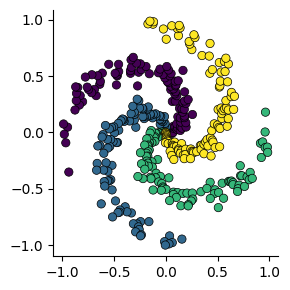

In [9]:
figure(figsize=(3,3))
scatter(x_train[:, 1], x_train[:, 2], c=t_train, lw=0.5, ec="k")
tight_layout()

In [23]:
# training θeter
n_traindata = size(x_train)[1]
n_batch = 10 # batch size
n_iter_per_epoch = round(Int, n_traindata/n_batch)
n_epoch = 5000; # number of epoch

In [38]:
nn_sd = MLP([2, 32, n_classes], [ReLU(), Softmax()], init_type="He") # sd: spiral dataset
loss_fun_sd = cross_entropy_loss

lr = 0.1  # learning rate
weight_decay = 0#1e-4 # weight decay (L2 norm) strength
optimizer_sd = SGD(lr=lr)
shuffle_data = true;

In [39]:
error_arr = zeros(n_epoch); # memory array of each epoch error
@showprogress "Training..." for e in 1:n_epoch
    if shuffle_data
        shuffle_indices = shuffle(1:n_traindata)
        x_train = x_train[shuffle_indices, :];
        t_train = t_train[shuffle_indices]
    end
    
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x, t = x_train[idx, :], t_train[idx]
        loss = train_step!(nn_sd, x, t, loss_fun_sd, optimizer=optimizer_sd, weight_decay=weight_decay, mode="node")
        #loss = train_step!(nn_sd, x, t, loss_fun_sd, optimizer=optimizer_sd, weight_decay=weight_decay, mode="weight")
        error_arr[e] += loss
    end 
    error_arr[e] /= n_iter_per_epoch
end

Training... 100%|████████████████████████████████████████| Time: 0:00:05


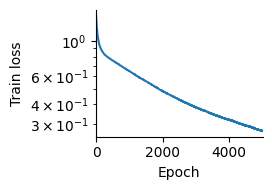

In [40]:
figure(figsize=(3,2))
semilogy(1:n_epoch, error_arr)
ylabel("Train loss"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

In [41]:
x = -1.1:0.05:1.1
y = -1.1:0.05:1.1
X = ones(length(x)) * x'
Y = y * ones(length(y))'

x_test = Matrix(hcat([[xx, yy] for xx in x for yy in y]...)')
y_pred = nn_sd(x_test)
t_pred = 1.0*vec([inds[2] for inds in argmax(y_pred, dims=2)]);
T = reshape(t_pred, (length(x), length(y)));

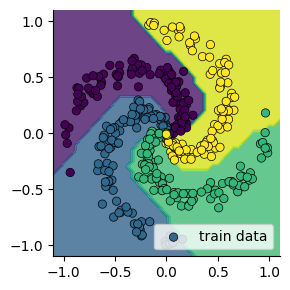

In [42]:
figure(figsize=(3,3))
contourf(X, Y, T, alpha=0.8)
scatter(x_train[:, 1], x_train[:, 2], c=t_train, lw=0.5, ec="k", label="train data")
legend()
tight_layout()